In [1]:
from easyclean import datasets
import pandas as pd
from utils import sequence_utils
from sklearn.model_selection import train_test_split
import torch
import numpy as np
from torch import nn, optim
from transformers import BertModel, AdamW, get_linear_schedule_with_warmup
from collections import defaultdict


In [2]:
class_names = ['negative', 'positive']
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
MAX_LEN = 160
BATCH_SIZE = 16



In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(device)
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print(device)
else:
    device = torch.device("cpu")
    print(device)

mps


In [4]:
originalDataset = "datasets/IMDBDatasetSPANISH.csv"
pandasDF = pd.read_csv(originalDataset)
filas = ['review_es', 'sentiment'] #columnas por mantener
DF_IMDB = datasets.delete(pandasDF, filas)
print(DF_IMDB)

                                               review_es sentiment
0      Uno de los otros críticos ha mencionado que de...  positive
1      Una pequeña pequeña producción.La técnica de f...  positive
2      Pensé que esta era una manera maravillosa de p...  positive
3      Básicamente, hay una familia donde un niño peq...  negative
4      El "amor en el tiempo" de Petter Mattei es una...  positive
...                                                  ...       ...
49995  Pensé que esta película hizo un buen trabajo a...  positive
49996  Mala parcela, mal diálogo, mala actuación, dir...  negative
49997  Soy católica enseñada en escuelas primarias pa...  negative
49998  Voy a tener que estar en desacuerdo con el com...  negative
49999  Nadie espera que las películas de Star Trek se...  negative

[50000 rows x 2 columns]


In [5]:
DF_IMDB = sequence_utils.filter_string(DF_IMDB, 'review_es',160)
print(DF_IMDB)

                                               review_es sentiment
3      Básicamente, hay una familia donde un niño peq...  negative
5      Probablemente mi película favorita de todos lo...  positive
6      Seguro que me gustaría ver una resurrección de...  positive
8      Alentados por los comentarios positivos sobre ...  negative
9      Si te gusta la risa original desgarradora, te ...  positive
...                                                  ...       ...
49987  Una nueva versión de Alejandro Amenabar's Abre...  negative
49990  Cojo, cojo, cojo !!!Un festival de 90 minutos ...  negative
49994  Esta es tu comedia de chatarra típica. Casi no...  negative
49996  Mala parcela, mal diálogo, mala actuación, dir...  negative
49999  Nadie espera que las películas de Star Trek se...  negative

[22692 rows x 2 columns]


In [6]:
def to_sentiment(sentiment):
    sentiment = str(sentiment)
    if sentiment == 'positive':
        return 1
    elif sentiment == 'negative':
        return 0
    

In [7]:
DF_IMDB['sentiment'] = DF_IMDB.sentiment.apply(to_sentiment)
DF_IMDB

,review_es,sentiment
3,"Básicamente, hay una familia donde un niño peq...",0
5,Probablemente mi película favorita de todos lo...,1
6,Seguro que me gustaría ver una resurrección de...,1
8,Alentados por los comentarios positivos sobre ...,0
9,"Si te gusta la risa original desgarradora, te ...",1
...,...,...
49987,Una nueva versión de Alejandro Amenabar's Abre...,0
49990,"Cojo, cojo, cojo !!!Un festival de 90 minutos ...",0
49994,Esta es tu comedia de chatarra típica. Casi no...,0
49996,"Mala parcela, mal diálogo, mala actuación, dir...",0


In [8]:
listDatasets = [DF_IMDB, "datasets/filmaffinity", "datasets/muchocine", 2]
headers = ['content', 'sentiment']
newDatasets = datasets.join(listDatasets, headers)
print(newDatasets)
print(newDatasets.shape)

undetected element with index: 3
                                                 content  sentiment
0      Básicamente, hay una familia donde un niño peq...          0
1      Probablemente mi película favorita de todos lo...          1
2      Seguro que me gustaría ver una resurrección de...          1
3      Alentados por los comentarios positivos sobre ...          0
4      Si te gusta la risa original desgarradora, te ...          1
...                                                  ...        ...
35162  Película dirigida a un público adolescente, co...          0
35163  Bergman en estado puro. Duro a la par que sens...          0
35164  Por fin vemos un Almodóvar que retrata escenas...          0
35165  Dos horas entretenidillas de thriller con cier...          0
35166  La película es entretenida e interesante, sobr...          0

[35167 rows x 2 columns]
(35167, 2)


In [9]:
newDatasets

,content,sentiment
0,"Básicamente, hay una familia donde un niño peq...",0
1,Probablemente mi película favorita de todos lo...,1
2,Seguro que me gustaría ver una resurrección de...,1
3,Alentados por los comentarios positivos sobre ...,0
4,"Si te gusta la risa original desgarradora, te ...",1
...,...,...
35162,"Película dirigida a un público adolescente, co...",0
35163,Bergman en estado puro. Duro a la par que sens...,0
35164,Por fin vemos un Almodóvar que retrata escenas...,0
35165,Dos horas entretenidillas de thriller con cier...,0


In [10]:
newDatasets.describe()

,sentiment
count,35167.000000
mean,0.450309
std,0.497532
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [11]:
print(newDatasets['sentiment'].value_counts())


sentiment
0    19331
1    15836
Name: count, dtype: int64


In [12]:
tempDataframe = sequence_utils.filter_string(newDatasets, 'content',160)

In [13]:
tempDataframe

,content,sentiment
0,"Básicamente, hay una familia donde un niño peq...",0
1,Probablemente mi película favorita de todos lo...,1
2,Seguro que me gustaría ver una resurrección de...,1
3,Alentados por los comentarios positivos sobre ...,0
4,"Si te gusta la risa original desgarradora, te ...",1
...,...,...
35162,"Película dirigida a un público adolescente, co...",0
35163,Bergman en estado puro. Duro a la par que sens...,0
35164,Por fin vemos un Almodóvar que retrata escenas...,0
35165,Dos horas entretenidillas de thriller con cier...,0


In [15]:
print(tempDataframe['sentiment'].value_counts())

sentiment
0    16870
1    13729
Name: count, dtype: int64


In [16]:
from transformers import BertTokenizer

In [17]:
PRE_TRAINED_MODEL_NAME = 'dccuchile/bert-base-spanish-wwm-cased'

In [18]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/Users/jose/Documents/thesis/RecSys/utils/sequence_utils.py:44: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


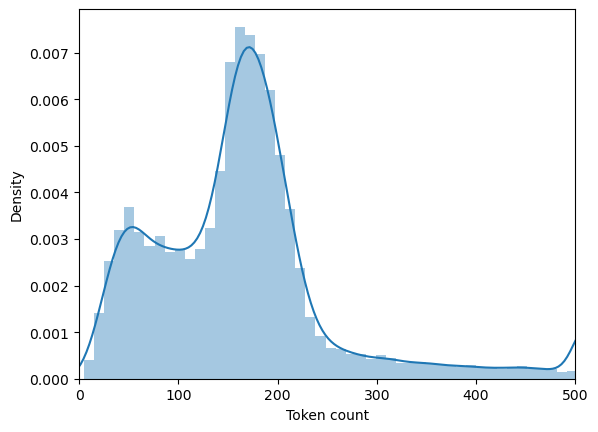

In [17]:
sequence_utils.plot_token_count(newDatasets.content, tokenizer)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/Users/jose/Documents/thesis/RecSys/utils/sequence_utils.py:44: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


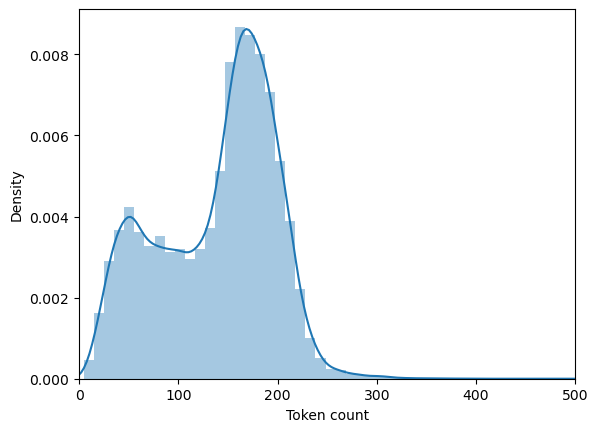

In [19]:
sequence_utils.plot_token_count(tempDataframe.content, tokenizer)

In [20]:
df_train, df_test = train_test_split(tempDataframe, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [21]:
df_train.shape, df_val.shape, df_test.shape

((27539, 2), (1530, 2), (1530, 2))

In [22]:
train_data_loader = sequence_utils.my_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = sequence_utils.my_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = sequence_utils.my_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [23]:
train_data_loader

In [ ]:
#bert_model = BertModel.from_pretrained("dccuchile/bert-base-spanish-wwm-cased")

In [24]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained("dccuchile/bert-base-spanish-wwm-cased")
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask, return_dict):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask, return_dict=False
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [25]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
model

SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [27]:
EPOCHS = 5

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

/Users/jose/miniforge3/envs/myclone/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [28]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask, return_dict= False
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  ####Error aqui
  return correct_predictions.double() / n_examples, np.mean(losses)

In [29]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask, return_dict= False
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  #Error no viene de aqui, por ahora:
  #print("correct_predictions", correct_predictions)  
  #print("correct_predictions.double()", correct_predictions.double()) 
  #print("n_examples", n_examples) 
  #print("losses", losses)
  #print("np.mean(losses)", np.mean(losses))
  return correct_predictions.double() / n_examples, np.mean(losses)

In [30]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_beto_model_state.bin')
    best_accuracy = val_acc

Epoch 1/5
----------


/Users/jose/miniforge3/envs/myclone/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2622: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


TypeError: Cannot convert a MPS Tensor to float64 dtype as the MPS framework doesn't support float64. Please use float32 instead.